In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la

from src.structured_random_features.src.models.weights import V1_weights

# Packages for fft and fitting data
from scipy import fftpack as fft
from sklearn.linear_model import Lasso

# Package for importing image representation
from PIL import Image, ImageOps

from src.V1_Compress import generate_Y, compress
import pandas as pd
import itertools
import dask
from dask.distributed import Client, progress
import seaborn as sns
import time
import os.path

In [57]:
def opt_hyperparams(data): 
    # Try to use pd group_by to group repetition and get avg
    
    # Among those average, get the lowest error hyperparam
    ordered_data = pd.DataFrame(data).sort_values(by = 'error', ascending = True)
    print(ordered_data.head(5))
    
    return ordered_data.head(1)

In [31]:
def run_sim(rep, alpha, num, sz, freq, img_arr = img_arr):
    img_arr = np.array([img_arr]).squeeze()
    dim = img_arr.shape
    n, m = dim

    # Generate V1 weight with y
    W = V1_weights(num, dim, sz, freq) 
    y = generate_Y(W, img_arr)
    W_model = W.reshape(num, n, m)
    
    # Call function and calculate error
    theta, reform, s = compress(W_model, y, alp)
    error = np.linalg.norm(img - reform, 'fro') / np.sqrt(m*n)
    
    return error, theta, reform, s

In [32]:
#DF version after looking at Desk method

# Set up hyperparameters that would affect results
param = []
params = []
# result = []
alpha = np.logspace(-3, 3, 7)
rep = np.arange(10)
num_cell = [100, 200, 500]
cell_sz = [2, 5, 7]
sparse_freq = [1, 2, 5]

# Load Image
image_nm = 'image/tree_part1.jpg'
img = Image.open(image_nm)
img = ImageOps.grayscale(img)
img_arr = np.asarray(img)



search_list = [rep, alpha, num_cell, cell_sz, sparse_freq]
search = list(itertools.product(*search_list))             
search_df = pd.DataFrame(search, columns= [ 'rep', 'alp', 'num_cell', 'cell_sz', 'sparse_freq'])
print(search_df.head())

# Call dask
client = Client()
client

# counter = 0; # Keep track of number of iteration. Debugging method
for p in search_df.values:
    param = dask.delayed(run_sim)(*p)
    params.append(param)
#     counter+=1
#     print("iteration: ", counter)
    
futures = dask.persist(*params)
progress(futures)

# print("Before computing the process")
# results = dask.compute(*process)
# print("Computing over")
# results = pd.DataFrame(results, columns = ['error', 'theta', 'reform', 's'])
# print("results DataFramed")



# Load V1 weight
# dim = img_arr.shape
# n, m = dim

# # use itertool to reduce amount of for loops
# for row in itertools.product(*search_list.values()):
#     product = dict(zip(search_list.keys(), row))
#     epo, alp, num, sz, freq = product.values()
#     W = V1_weights(num, dim, sz, freq) 
#     y = generate_Y(W, img_arr)
#     W_model = W.reshape(num, n, m)
    
#     theta, reform, s = compress(W_model, y, alp)
#     error = np.linalg.norm(img - reform, 'fro') / np.sqrt(m*n)
    
#     params.append({'repetition' : rep,
#                    'num_cell' : num,
#                    'cell_size' : sz,
#                    'sparse_freq' : freq,
#                    'alpha': alp,
#                    'error' : error
#                   })
# opt_param = opt_hyperparams(params)

   rep    alp  num_cell  cell_sz  sparse_freq
0    0  0.001       100        2            1
1    0  0.001       100        2            2
2    0  0.001       100        2            5
3    0  0.001       100        5            1
4    0  0.001       100        5            2


/home/bans/anaconda3/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39063 instead
  warnings.warn(


VBox()

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (4.0, 10.0, 500.0, 5.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (8.0, 10.0, 200.0, 2.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (8.0, 100.0, 100.0, 7.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (0.0, 0.1, 200.0, 7.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (9.0, 1.0, 200.0, 7.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (3.0, 1000.0, 500.0,

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (5.0, 1.0, 100.0, 5.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (7.0, 10.0, 100.0, 5.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (9.0, 1000.0, 100.0, 7.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (1.0, 1.0, 500.0, 5.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (9.0, 0.1, 100.0, 2.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (6.0, 0.1, 200.0, 2.

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (5.0, 1000.0, 200.0, 5.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (6.0, 0.1, 100.0, 7.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (8.0, 100.0, 500.0, 2.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (7.0, 1000.0, 100.0, 2.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (7.0, 1000.0, 500.0, 2.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (9.0, 1000.0,

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (2.0, 1.0, 100.0, 7.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (1.0, 0.001, 100.0, 2.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (0.0, 10.0, 100.0, 5.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (6.0, 10.0, 500.0, 7.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (8.0, 1000.0, 100.0, 7.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (1.0, 100.0, 500.

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (8.0, 10.0, 500.0, 2.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (4.0, 0.01, 500.0, 2.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (2.0, 0.01, 200.0, 5.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (8.0, 10.0, 200.0, 2.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (5.0, 0.1, 500.0, 2.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (1.0, 0.1, 500.0, 2.

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (7.0, 0.001, 500.0, 7.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (3.0, 1000.0, 200.0, 7.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (5.0, 1000.0, 100.0, 7.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (9.0, 0.001, 500.0, 7.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (5.0, 0.01, 500.0, 2.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (4.0, 0.1, 10

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (3.0, 0.1, 500.0, 2.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (3.0, 0.1, 200.0, 2.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (8.0, 1.0, 500.0, 2.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (6.0, 0.01, 500.0, 7.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (9.0, 1.0, 500.0, 2.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (9.0, 0.01, 200.0, 5.0,

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (0.0, 1.0, 200.0, 5.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (9.0, 100.0, 200.0, 7.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (1.0, 0.01, 200.0, 7.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (7.0, 10.0, 500.0, 7.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (2.0, 0.001, 500.0, 7.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (2.0, 0.01, 100.0,

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (9.0, 0.01, 100.0, 7.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (2.0, 100.0, 200.0, 2.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (9.0, 1000.0, 200.0, 5.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (7.0, 0.01, 100.0, 5.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (6.0, 1000.0, 500.0, 5.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (5.0, 0.01, 10

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (8.0, 10.0, 100.0, 2.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (5.0, 0.1, 500.0, 7.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (0.0, 1000.0, 100.0, 2.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (8.0, 0.001, 100.0, 5.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (2.0, 100.0, 500.0, 7.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (9.0, 100.0, 100

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (8.0, 1000.0, 100.0, 2.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (8.0, 0.01, 500.0, 7.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (8.0, 1000.0, 500.0, 7.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (7.0, 0.001, 500.0, 5.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (7.0, 0.1, 100.0, 2.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (8.0, 100.0, 50

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (5.0, 1000.0, 500.0, 5.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (7.0, 0.01, 100.0, 7.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (9.0, 0.01, 100.0, 7.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (4.0, 0.001, 200.0, 7.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (6.0, 0.1, 500.0, 7.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (7.0, 10.0, 200.0

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (3.0, 0.1, 500.0, 7.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (9.0, 10.0, 100.0, 2.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (0.0, 0.01, 500.0, 2.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (6.0, 0.01, 200.0, 7.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (2.0, 0.1, 200.0, 5.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (5.0, 1.0, 200.0, 7.0

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (0.0, 0.1, 200.0, 7.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (6.0, 0.1, 100.0, 2.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (4.0, 1.0, 500.0, 5.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (6.0, 100.0, 200.0, 5.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (5.0, 0.001, 200.0, 7.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (7.0, 1.0, 200.0, 2.

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (6.0, 0.1, 100.0, 2.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (9.0, 10.0, 500.0, 2.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (0.0, 1.0, 500.0, 2.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (3.0, 10.0, 200.0, 7.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (8.0, 1.0, 200.0, 7.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (0.0, 0.01, 500.0, 7.0

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (6.0, 0.1, 200.0, 7.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (8.0, 1.0, 200.0, 2.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (8.0, 10.0, 100.0, 5.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (2.0, 0.1, 100.0, 7.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (5.0, 0.001, 100.0, 7.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (4.0, 100.0, 200.0, 5

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (6.0, 1000.0, 100.0, 7.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (8.0, 1000.0, 200.0, 7.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (5.0, 10.0, 100.0, 2.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (7.0, 1000.0, 100.0, 7.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (4.0, 0.1, 500.0, 2.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (4.0, 10.0, 50

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (1.0, 0.01, 100.0, 5.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (6.0, 100.0, 500.0, 7.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (8.0, 0.001, 500.0, 5.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (8.0, 1.0, 200.0, 7.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (3.0, 10.0, 100.0, 5.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (4.0, 1.0, 100.0, 

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (7.0, 0.01, 500.0, 2.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (0.0, 1000.0, 500.0, 7.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (3.0, 10.0, 500.0, 2.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (9.0, 10.0, 500.0, 5.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (1.0, 100.0, 500.0, 2.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (5.0, 0.1, 500.0

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (2.0, 0.1, 200.0, 2.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (8.0, 100.0, 100.0, 2.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (6.0, 100.0, 500.0, 5.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (5.0, 1000.0, 500.0, 5.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (3.0, 1.0, 500.0, 7.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (1.0, 0.01, 100.0

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (2.0, 10.0, 200.0, 7.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (8.0, 100.0, 500.0, 5.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (5.0, 0.01, 200.0, 7.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (0.0, 0.01, 500.0, 7.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (0.0, 0.001, 200.0, 7.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (8.0, 0.001, 500.

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (0.0, 10.0, 500.0, 2.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (2.0, 0.001, 500.0, 2.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (2.0, 1000.0, 100.0, 2.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (7.0, 0.01, 100.0, 7.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (3.0, 10.0, 500.0, 2.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (9.0, 0.1, 100.0

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (4.0, 0.1, 100.0, 2.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (9.0, 10.0, 200.0, 2.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (3.0, 100.0, 200.0, 5.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (4.0, 0.01, 200.0, 5.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (6.0, 0.1, 500.0, 5.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (0.0, 0.001, 100.0, 

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (7.0, 0.1, 500.0, 5.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (3.0, 0.001, 500.0, 7.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (7.0, 100.0, 100.0, 7.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (4.0, 1000.0, 500.0, 2.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (7.0, 100.0, 500.0, 5.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (3.0, 0.001, 10

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (6.0, 1.0, 500.0, 7.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (3.0, 1.0, 100.0, 7.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (1.0, 1000.0, 500.0, 7.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (6.0, 0.001, 100.0, 2.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (0.0, 1.0, 200.0, 7.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (5.0, 0.01, 200.0, 

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (3.0, 10.0, 500.0, 5.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (9.0, 100.0, 100.0, 7.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (5.0, 100.0, 500.0, 7.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (3.0, 1000.0, 200.0, 7.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (9.0, 10.0, 100.0, 7.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (0.0, 10.0, 200

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (1.0, 10.0, 100.0, 5.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (3.0, 0.01, 500.0, 7.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (3.0, 0.001, 100.0, 2.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (2.0, 1.0, 100.0, 2.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (3.0, 1.0, 100.0, 5.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (8.0, 100.0, 200.0, 

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (3.0, 0.1, 200.0, 5.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (8.0, 0.01, 100.0, 7.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (6.0, 0.1, 500.0, 7.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (4.0, 0.001, 200.0, 7.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (3.0, 0.01, 200.0, 2.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (0.0, 100.0, 500.0, 

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (9.0, 0.1, 200.0, 7.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (4.0, 0.01, 500.0, 5.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (7.0, 0.01, 500.0, 5.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (9.0, 100.0, 200.0, 5.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (5.0, 1000.0, 200.0, 7.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (3.0, 0.1, 100.0,

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (0.0, 0.01, 200.0, 7.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (6.0, 0.001, 100.0, 5.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (0.0, 0.01, 100.0, 2.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (7.0, 1.0, 100.0, 5.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (6.0, 0.001, 500.0, 2.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (9.0, 0.01, 200.0,

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (9.0, 10.0, 200.0, 7.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (0.0, 0.01, 200.0, 5.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (2.0, 1.0, 500.0, 7.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (7.0, 0.1, 100.0, 2.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (2.0, 0.001, 100.0, 5.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (7.0, 0.1, 100.0, 7.

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (3.0, 10.0, 200.0, 2.0, 5.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (2.0, 100.0, 200.0, 7.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (7.0, 0.1, 500.0, 7.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (7.0, 1.0, 200.0, 2.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (9.0, 0.01, 500.0, 7.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (0.0, 0.1, 200.0, 5.

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (3.0, 0.1, 100.0, 7.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (4.0, 0.001, 100.0, 7.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (9.0, 0.1, 200.0, 2.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (5.0, 1000.0, 100.0, 5.0, 2.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (3.0, 0.01, 200.0, 7.0, 1.0)
kwargs:    {}
Exception: "IndexError('invalid index to scalar variable.')"

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (1.0, 100.0, 100.0

In [5]:
# This works but other ways does not work at all for no reason

params = []
reformed = []
alpha = np.logspace(-3, 3, 7)
rep = np.arange(10)
results = []

# Load Image
image_nm = 'image/tree_part1.jpg'
img = Image.open(image_nm)
img = ImageOps.grayscale(img)
img_arr = np.asarray(img)


# Load V1 weight
search_list = {'repetition': rep,
               'alpha': alpha,
               'num_cell': [100, 200, 500],
               'cell_sz': [2, 5, 7],
               'sparse_freq': [1, 2, 5]
              }

dim = img_arr.shape
n, m = dim

# use itertool to reduce amount of for loops
for row in itertools.product(*search_list.values()):
    product = dict(zip(search_list.keys(), row))
    rep, alp, num, sz, freq = product.values()
    W = V1_weights(num, dim, sz, freq) 
    y = generate_Y(W, img_arr)
    W_model = W.reshape(num, n, m)
    
    theta, reform, s = compress(W_model, y, alp)
    error = np.linalg.norm(img - reform, 'fro') / np.sqrt(m*n)
    
    
    
    params.append({'repetition' : rep,
                   'num_cell' : num,
                   'cell_size' : sz,
                   'sparse_freq' : freq,
                   'alpha': alp,
                   'error' : error
                  })
    
    
    results.append({'s' : s,
                    'theta' : theta,
                    'reform' : reform
                   })
# opt_param = opt_hyperparams(params)

In [6]:
#Saving 
save_path = os.path.join('./result/')
params_df = pd.DataFrame(params)
results_df = pd.DataFrame(results)

total_df = params_df.join(results_df)

params_df.to_csv(os.path.join(save_path, "param_" + "_".join(str.split(time.ctime().replace(":", "_"))) + ".csv"))
results_df.to_csv(os.path.join(save_path, "results_" + "_".join(str.split(time.ctime().replace(":", "_"))) + ".csv"))
total_df.to_csv(os.path.join(save_path, "total_" + "_".join(str.split(time.ctime().replace(":", "_"))) + ".csv"))


In [7]:
# Work on previously saved data
params_df = pd.read_csv('result//param_Mon_May_23_21_46_49_2022.csv')
results_df = pd.read_csv('result//results_Mon_May_23_21_46_49_2022.csv')
total_df = pd.read_csv('result//total_Mon_May_23_21_47_07_2022.csv')

In [8]:
params_df

,Unnamed: 0,repetition,num_cell,cell_size,sparse_freq,alpha,error
0,0,0,100,2,1,0.001,118.552402
1,1,0,100,2,2,0.001,1517.257701
2,2,0,100,2,5,0.001,2642.888029
3,3,0,100,5,1,0.001,122.698407
4,4,0,100,5,2,0.001,1334.387078
...,...,...,...,...,...,...,...
1885,1885,9,500,5,2,1000.000,28.332152
1886,1886,9,500,5,5,1000.000,29.203209
1887,1887,9,500,7,1,1000.000,37.352217
1888,1888,9,500,7,2,1000.000,30.094042


In [9]:
W

array([[ 0.        ,  0.        ,  0.        , ...,  0.4735036 ,
         0.16126508, -0.00690414],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.98200229,  1.21817967,  1.37094052, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.29631592,  2.90676488,  3.71407589, ...,  0.        ,
         0.        ,  0.        ]])

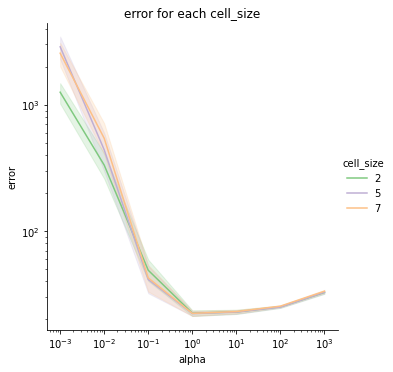

In [10]:
fig = sns.relplot(data = params_df, x = 'alpha', y = 'error', kind='line', palette='Accent', hue = 'cell_size')
fig.set(yscale='log')
fig.set(xscale='log')
fig.set(title='error for each cell_size')

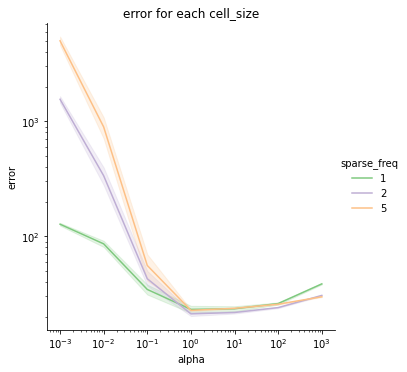

In [11]:
fig = sns.relplot(data = params_df, x = 'alpha', y = 'error', kind='line', palette='Accent', hue = 'sparse_freq')
fig.set(yscale='log')
fig.set(xscale='log')
fig.set(title='error for each cell_size')

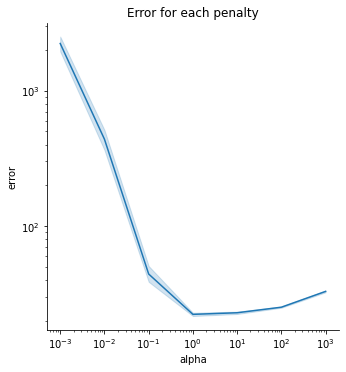

In [12]:
fig = sns.relplot(data = params_df, x = 'alpha', y = 'error', kind='line')
fig.set(yscale='log')
fig.set(xscale='log')
fig.set(title='Error for each penalty')

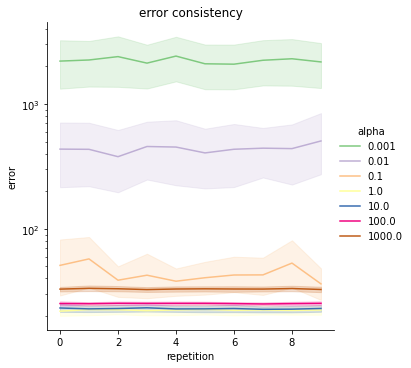

In [13]:
# To show how consistent randomly generated V1 weight would be for each rep. it should be about same for each repetition


fig = sns.relplot(data = params_df, x = 'repetition', y = 'error', kind='line', palette='Accent', hue = 'alpha')
fig.set(title='error consistency')
fig.set(yscale='log')

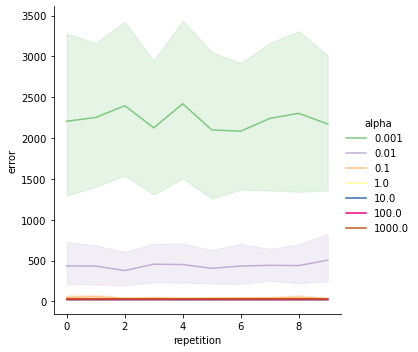

In [14]:
sns.relplot(data = params_df, x = 'repetition', y = 'error', kind='line', palette='Accent', hue = 'alpha')

<Figure size 216x216 with 0 Axes>

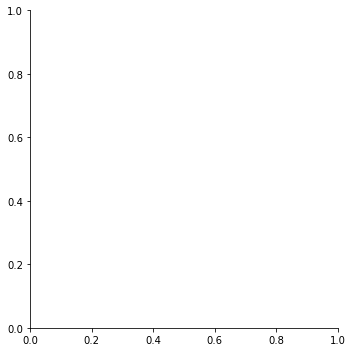

In [15]:
plt.figure(figsize=(3, 3))
fig = sns.relplot()

In [144]:

alpha = np.logspace(-3, 3, 7)
rep = np.arange(10)
num_cell = [100, 200, 500]
cell_sz = [2, 5, 7]
sparse_freq = [1, 2, 5]

# Load Image
image_nm = 'city_part3.png'
img = Image.open('image/' + image_nm)
img = ImageOps.grayscale(img)
img_arr = np.asarray(img)

dim = img_arr.shape
n, m = dim

# Load V1 weight
# search_list = {'repetition': rep,
#                'alpha': alpha,
#                'num_cell': ,
#                'cell_sz': [2, 5, 7],
#                'sparse_freq': [1, 2, 5]
#               }

temp_alp = 3
temp_num = 200
temp_sz = 5
temp_freq = 5

temp_dim = img_arr.shape

temp_W = V1_weights(temp_num, dim, temp_sz, temp_freq)


search_list = [rep, alpha, num_cell, cell_sz, sparse_freq]
search = list(itertools.product(*search_list))             
search_df = pd.DataFrame(search, columns= [ 'rep', 'alp', 'num_cell', 'cell_sz', 'sparse_freq'])


result = pd.DataFrame(columns=['s', 'theta', 'reform', 'error'])
# use itertool to reduce amount of for loops
# for row in itertools.product(*search_list.values()):

search_result = []
print("start for loop")
for rep, alp, num, sz, freq in list(search_df.values):
    print("repetition:", rep, "alpha:", alp, "num_Cell:", num, "Cell Size:", sz, 
          "Cell_Freq:", freq, "Dim", dim[0], dim[1])
    
    # fix the classes of hyperparameter from float to int if needed
    rep = int(rep)
    num = int(num)
    sz = int(sz)
    freq = int(freq)

    # Generate V1 weight with Y values
    W = V1_weights(num, dim, sz, freq) 
    y = generate_Y(W, img_arr)
    W_model = W.reshape(num, n, m)

    # Compute bio-reconstruction of image with error
    theta, reform, s = compress(W_model, y, alp)
    error = np.linalg.norm(img - reform, 'fro') / np.sqrt(m*n)
    print("Error:", error)
    
    # Save result 
    search_result.append({'repetition' : rep,
                          'num_cell' : num,
                          'cell_size' : sz,
                          'sparse_freq' : freq,
                          'alpha': alp,
                          'error' : error
                         })
opt_param = opt_hyperparams(search_result)

start for loop
repetition: 0.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 2.0 Cell_Freq: 1.0 Dim 30 30
Error: 103.26867701372089
repetition: 0.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 2.0 Cell_Freq: 2.0 Dim 30 30
Error: 1186.842511811156
repetition: 0.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 2.0 Cell_Freq: 5.0 Dim 30 30
Error: 2319.3058110931283
repetition: 0.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 5.0 Cell_Freq: 1.0 Dim 30 30
Error: 101.24129901211775
repetition: 0.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 5.0 Cell_Freq: 2.0 Dim 30 30
Error: 1693.1527444094932
repetition: 0.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 5.0 Cell_Freq: 5.0 Dim 30 30
Error: 4294.030304120137
repetition: 0.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 7.0 Cell_Freq: 1.0 Dim 30 30
Error: 97.7162895197012
repetition: 0.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 7.0 Cell_Freq: 2.0 Dim 30 30
Error: 1128.807150515095
repetition: 0.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 7.0 Cell_Freq: 5.0 Dim 30 30
Error: 2645.56288

Error: 21.94428515670925
repetition: 0.0 alpha: 0.1 num_Cell: 500.0 Cell Size: 5.0 Cell_Freq: 1.0 Dim 30 30
Error: 19.079343703516727
repetition: 0.0 alpha: 0.1 num_Cell: 500.0 Cell Size: 5.0 Cell_Freq: 2.0 Dim 30 30
Error: 18.756509508720004
repetition: 0.0 alpha: 0.1 num_Cell: 500.0 Cell Size: 5.0 Cell_Freq: 5.0 Dim 30 30
Error: 27.261218256121303
repetition: 0.0 alpha: 0.1 num_Cell: 500.0 Cell Size: 7.0 Cell_Freq: 1.0 Dim 30 30
Error: 16.368431990698912
repetition: 0.0 alpha: 0.1 num_Cell: 500.0 Cell Size: 7.0 Cell_Freq: 2.0 Dim 30 30
Error: 18.50327828070882
repetition: 0.0 alpha: 0.1 num_Cell: 500.0 Cell Size: 7.0 Cell_Freq: 5.0 Dim 30 30
Error: 24.402691435697545
repetition: 0.0 alpha: 1.0 num_Cell: 100.0 Cell Size: 2.0 Cell_Freq: 1.0 Dim 30 30
Error: 37.498041373880476
repetition: 0.0 alpha: 1.0 num_Cell: 100.0 Cell Size: 2.0 Cell_Freq: 2.0 Dim 30 30
Error: 38.1904882152244
repetition: 0.0 alpha: 1.0 num_Cell: 100.0 Cell Size: 2.0 Cell_Freq: 5.0 Dim 30 30
Error: 30.6089209911763

Error: 31.151699602608495
repetition: 0.0 alpha: 100.0 num_Cell: 200.0 Cell Size: 7.0 Cell_Freq: 2.0 Dim 30 30
Error: 30.690597997928244
repetition: 0.0 alpha: 100.0 num_Cell: 200.0 Cell Size: 7.0 Cell_Freq: 5.0 Dim 30 30
Error: 33.05641546300705
repetition: 0.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 2.0 Cell_Freq: 1.0 Dim 30 30
Error: 27.34636524598252
repetition: 0.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 2.0 Cell_Freq: 2.0 Dim 30 30
Error: 27.687725879358776
repetition: 0.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 2.0 Cell_Freq: 5.0 Dim 30 30
Error: 29.932784358321943
repetition: 0.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 5.0 Cell_Freq: 1.0 Dim 30 30
Error: 28.395777387620846
repetition: 0.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 5.0 Cell_Freq: 2.0 Dim 30 30
Error: 29.40145247690818
repetition: 0.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 5.0 Cell_Freq: 5.0 Dim 30 30
Error: 32.36720915395691
repetition: 0.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 7.0 Cell_Freq: 1.0 Dim 30 30
Error

Error: 80.4184998992384
repetition: 1.0 alpha: 0.01 num_Cell: 200.0 Cell Size: 2.0 Cell_Freq: 2.0 Dim 30 30
Error: 184.3516810503365
repetition: 1.0 alpha: 0.01 num_Cell: 200.0 Cell Size: 2.0 Cell_Freq: 5.0 Dim 30 30
Error: 614.2479583471797
repetition: 1.0 alpha: 0.01 num_Cell: 200.0 Cell Size: 5.0 Cell_Freq: 1.0 Dim 30 30
Error: 87.08552091291192
repetition: 1.0 alpha: 0.01 num_Cell: 200.0 Cell Size: 5.0 Cell_Freq: 2.0 Dim 30 30
Error: 169.93616300133164
repetition: 1.0 alpha: 0.01 num_Cell: 200.0 Cell Size: 5.0 Cell_Freq: 5.0 Dim 30 30
Error: 71.9543384880527
repetition: 1.0 alpha: 0.01 num_Cell: 200.0 Cell Size: 7.0 Cell_Freq: 1.0 Dim 30 30
Error: 71.35000855573408
repetition: 1.0 alpha: 0.01 num_Cell: 200.0 Cell Size: 7.0 Cell_Freq: 2.0 Dim 30 30
Error: 194.78744133335232
repetition: 1.0 alpha: 0.01 num_Cell: 200.0 Cell Size: 7.0 Cell_Freq: 5.0 Dim 30 30
Error: 633.6550073954345
repetition: 1.0 alpha: 0.01 num_Cell: 500.0 Cell Size: 2.0 Cell_Freq: 1.0 Dim 30 30
Error: 58.754504672

Error: 30.618521321050526
repetition: 1.0 alpha: 10.0 num_Cell: 100.0 Cell Size: 5.0 Cell_Freq: 5.0 Dim 30 30
Error: 31.140495965457433
repetition: 1.0 alpha: 10.0 num_Cell: 100.0 Cell Size: 7.0 Cell_Freq: 1.0 Dim 30 30
Error: 41.34876426194594
repetition: 1.0 alpha: 10.0 num_Cell: 100.0 Cell Size: 7.0 Cell_Freq: 2.0 Dim 30 30
Error: 30.363744431362555
repetition: 1.0 alpha: 10.0 num_Cell: 100.0 Cell Size: 7.0 Cell_Freq: 5.0 Dim 30 30
Error: 31.665630936162234
repetition: 1.0 alpha: 10.0 num_Cell: 200.0 Cell Size: 2.0 Cell_Freq: 1.0 Dim 30 30
Error: 30.892203600920432
repetition: 1.0 alpha: 10.0 num_Cell: 200.0 Cell Size: 2.0 Cell_Freq: 2.0 Dim 30 30
Error: 27.209440827294557
repetition: 1.0 alpha: 10.0 num_Cell: 200.0 Cell Size: 2.0 Cell_Freq: 5.0 Dim 30 30
Error: 28.930888335002262
repetition: 1.0 alpha: 10.0 num_Cell: 200.0 Cell Size: 5.0 Cell_Freq: 1.0 Dim 30 30
Error: 29.665222724480092
repetition: 1.0 alpha: 10.0 num_Cell: 200.0 Cell Size: 5.0 Cell_Freq: 2.0 Dim 30 30
Error: 25.3

Error: 35.42597170687863
repetition: 2.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 2.0 Cell_Freq: 1.0 Dim 30 30
Error: 104.838182520808
repetition: 2.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 2.0 Cell_Freq: 2.0 Dim 30 30
Error: 1583.020078410557
repetition: 2.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 2.0 Cell_Freq: 5.0 Dim 30 30
Error: 2098.1781701366735
repetition: 2.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 5.0 Cell_Freq: 1.0 Dim 30 30
Error: 108.62206000412198
repetition: 2.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 5.0 Cell_Freq: 2.0 Dim 30 30
Error: 1618.6007069310415
repetition: 2.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 5.0 Cell_Freq: 5.0 Dim 30 30
Error: 3144.294381501998
repetition: 2.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 7.0 Cell_Freq: 1.0 Dim 30 30
Error: 112.94483683695734
repetition: 2.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 7.0 Cell_Freq: 2.0 Dim 30 30
Error: 1489.812085769842
repetition: 2.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 7.0 Cell_Freq: 5.0 Dim 30 30
Error: 

Error: 18.21326281526298
repetition: 2.0 alpha: 0.1 num_Cell: 500.0 Cell Size: 5.0 Cell_Freq: 2.0 Dim 30 30
Error: 18.84628138895568
repetition: 2.0 alpha: 0.1 num_Cell: 500.0 Cell Size: 5.0 Cell_Freq: 5.0 Dim 30 30
Error: 27.0048866762779
repetition: 2.0 alpha: 0.1 num_Cell: 500.0 Cell Size: 7.0 Cell_Freq: 1.0 Dim 30 30
Error: 19.006914980796516
repetition: 2.0 alpha: 0.1 num_Cell: 500.0 Cell Size: 7.0 Cell_Freq: 2.0 Dim 30 30
Error: 19.224684764413023
repetition: 2.0 alpha: 0.1 num_Cell: 500.0 Cell Size: 7.0 Cell_Freq: 5.0 Dim 30 30
Error: 24.381099157932606
repetition: 2.0 alpha: 1.0 num_Cell: 100.0 Cell Size: 2.0 Cell_Freq: 1.0 Dim 30 30
Error: 37.717195450682354
repetition: 2.0 alpha: 1.0 num_Cell: 100.0 Cell Size: 2.0 Cell_Freq: 2.0 Dim 30 30
Error: 33.497489243566555
repetition: 2.0 alpha: 1.0 num_Cell: 100.0 Cell Size: 2.0 Cell_Freq: 5.0 Dim 30 30
Error: 33.4748606391105
repetition: 2.0 alpha: 1.0 num_Cell: 100.0 Cell Size: 5.0 Cell_Freq: 1.0 Dim 30 30
Error: 32.98771440848591


Error: 31.499224059492985
repetition: 2.0 alpha: 100.0 num_Cell: 200.0 Cell Size: 7.0 Cell_Freq: 2.0 Dim 30 30
Error: 30.167883405348757
repetition: 2.0 alpha: 100.0 num_Cell: 200.0 Cell Size: 7.0 Cell_Freq: 5.0 Dim 30 30
Error: 32.455588299639345
repetition: 2.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 2.0 Cell_Freq: 1.0 Dim 30 30
Error: 28.432627277971207
repetition: 2.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 2.0 Cell_Freq: 2.0 Dim 30 30
Error: 28.65271313862961
repetition: 2.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 2.0 Cell_Freq: 5.0 Dim 30 30
Error: 30.60128824133313
repetition: 2.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 5.0 Cell_Freq: 1.0 Dim 30 30
Error: 29.414085811721925
repetition: 2.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 5.0 Cell_Freq: 2.0 Dim 30 30
Error: 29.72908213344349
repetition: 2.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 5.0 Cell_Freq: 5.0 Dim 30 30
Error: 32.29637901048469
repetition: 2.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 7.0 Cell_Freq: 1.0 Dim 30 30
Error

Error: 80.10099022261714
repetition: 3.0 alpha: 0.01 num_Cell: 200.0 Cell Size: 2.0 Cell_Freq: 2.0 Dim 30 30
Error: 228.62672293591712
repetition: 3.0 alpha: 0.01 num_Cell: 200.0 Cell Size: 2.0 Cell_Freq: 5.0 Dim 30 30
Error: 339.4675776676198
repetition: 3.0 alpha: 0.01 num_Cell: 200.0 Cell Size: 5.0 Cell_Freq: 1.0 Dim 30 30
Error: 75.36530800879557
repetition: 3.0 alpha: 0.01 num_Cell: 200.0 Cell Size: 5.0 Cell_Freq: 2.0 Dim 30 30
Error: 212.8501102186874
repetition: 3.0 alpha: 0.01 num_Cell: 200.0 Cell Size: 5.0 Cell_Freq: 5.0 Dim 30 30
Error: 26.06448283932709
repetition: 3.0 alpha: 0.01 num_Cell: 200.0 Cell Size: 7.0 Cell_Freq: 1.0 Dim 30 30
Error: 75.6139832228468
repetition: 3.0 alpha: 0.01 num_Cell: 200.0 Cell Size: 7.0 Cell_Freq: 2.0 Dim 30 30
Error: 266.74999724064196
repetition: 3.0 alpha: 0.01 num_Cell: 200.0 Cell Size: 7.0 Cell_Freq: 5.0 Dim 30 30
Error: 323.46482354222394
repetition: 3.0 alpha: 0.01 num_Cell: 500.0 Cell Size: 2.0 Cell_Freq: 1.0 Dim 30 30
Error: 59.1768629

Error: 31.183762035061477
repetition: 3.0 alpha: 10.0 num_Cell: 100.0 Cell Size: 7.0 Cell_Freq: 1.0 Dim 30 30
Error: 37.858596981150704
repetition: 3.0 alpha: 10.0 num_Cell: 100.0 Cell Size: 7.0 Cell_Freq: 2.0 Dim 30 30
Error: 30.456702484108124
repetition: 3.0 alpha: 10.0 num_Cell: 100.0 Cell Size: 7.0 Cell_Freq: 5.0 Dim 30 30
Error: 31.49293521793252
repetition: 3.0 alpha: 10.0 num_Cell: 200.0 Cell Size: 2.0 Cell_Freq: 1.0 Dim 30 30
Error: 29.67854456865298
repetition: 3.0 alpha: 10.0 num_Cell: 200.0 Cell Size: 2.0 Cell_Freq: 2.0 Dim 30 30
Error: 26.46062904930985
repetition: 3.0 alpha: 10.0 num_Cell: 200.0 Cell Size: 2.0 Cell_Freq: 5.0 Dim 30 30
Error: 27.561957263714586
repetition: 3.0 alpha: 10.0 num_Cell: 200.0 Cell Size: 5.0 Cell_Freq: 1.0 Dim 30 30
Error: 26.751521596122174
repetition: 3.0 alpha: 10.0 num_Cell: 200.0 Cell Size: 5.0 Cell_Freq: 2.0 Dim 30 30
Error: 26.122136274420573
repetition: 3.0 alpha: 10.0 num_Cell: 200.0 Cell Size: 5.0 Cell_Freq: 5.0 Dim 30 30
Error: 30.908

Error: 95.29507319529813
repetition: 4.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 2.0 Cell_Freq: 2.0 Dim 30 30
Error: 1115.139005195563
repetition: 4.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 2.0 Cell_Freq: 5.0 Dim 30 30
Error: 1579.5017265870058
repetition: 4.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 5.0 Cell_Freq: 1.0 Dim 30 30
Error: 120.4721646041825
repetition: 4.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 5.0 Cell_Freq: 2.0 Dim 30 30
Error: 1620.0051100420087
repetition: 4.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 5.0 Cell_Freq: 5.0 Dim 30 30
Error: 5298.3398477851115
repetition: 4.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 7.0 Cell_Freq: 1.0 Dim 30 30
Error: 99.07772282771242
repetition: 4.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 7.0 Cell_Freq: 2.0 Dim 30 30
Error: 1026.0156654724356
repetition: 4.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 7.0 Cell_Freq: 5.0 Dim 30 30
Error: 3078.028399769736
repetition: 4.0 alpha: 0.001 num_Cell: 200.0 Cell Size: 2.0 Cell_Freq: 1.0 Dim 30 30
Error:

Error: 17.49672670899786
repetition: 4.0 alpha: 0.1 num_Cell: 500.0 Cell Size: 5.0 Cell_Freq: 2.0 Dim 30 30
Error: 18.782711278112984
repetition: 4.0 alpha: 0.1 num_Cell: 500.0 Cell Size: 5.0 Cell_Freq: 5.0 Dim 30 30
Error: 27.036617949000036
repetition: 4.0 alpha: 0.1 num_Cell: 500.0 Cell Size: 7.0 Cell_Freq: 1.0 Dim 30 30
Error: 19.451711699593886
repetition: 4.0 alpha: 0.1 num_Cell: 500.0 Cell Size: 7.0 Cell_Freq: 2.0 Dim 30 30
Error: 18.873516144125443
repetition: 4.0 alpha: 0.1 num_Cell: 500.0 Cell Size: 7.0 Cell_Freq: 5.0 Dim 30 30
Error: 24.0941722164133
repetition: 4.0 alpha: 1.0 num_Cell: 100.0 Cell Size: 2.0 Cell_Freq: 1.0 Dim 30 30
Error: 37.13581963822234
repetition: 4.0 alpha: 1.0 num_Cell: 100.0 Cell Size: 2.0 Cell_Freq: 2.0 Dim 30 30
Error: 36.732879119886114
repetition: 4.0 alpha: 1.0 num_Cell: 100.0 Cell Size: 2.0 Cell_Freq: 5.0 Dim 30 30
Error: 31.253768382805006
repetition: 4.0 alpha: 1.0 num_Cell: 100.0 Cell Size: 5.0 Cell_Freq: 1.0 Dim 30 30
Error: 37.5527790104902

Error: 31.175511629683943
repetition: 4.0 alpha: 100.0 num_Cell: 200.0 Cell Size: 7.0 Cell_Freq: 5.0 Dim 30 30
Error: 32.71631707944179
repetition: 4.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 2.0 Cell_Freq: 1.0 Dim 30 30
Error: 27.44102486802122
repetition: 4.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 2.0 Cell_Freq: 2.0 Dim 30 30
Error: 27.724090281714776
repetition: 4.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 2.0 Cell_Freq: 5.0 Dim 30 30
Error: 30.308996753892963
repetition: 4.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 5.0 Cell_Freq: 1.0 Dim 30 30
Error: 28.470999679697268
repetition: 4.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 5.0 Cell_Freq: 2.0 Dim 30 30
Error: 29.056170689244013
repetition: 4.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 5.0 Cell_Freq: 5.0 Dim 30 30
Error: 32.41012561725088
repetition: 4.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 7.0 Cell_Freq: 1.0 Dim 30 30
Error: 28.78873277709353
repetition: 4.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 7.0 Cell_Freq: 2.0 Dim 30 30
Error

Error: 171.32100070140197
repetition: 5.0 alpha: 0.01 num_Cell: 200.0 Cell Size: 2.0 Cell_Freq: 5.0 Dim 30 30
Error: 625.2593214066342
repetition: 5.0 alpha: 0.01 num_Cell: 200.0 Cell Size: 5.0 Cell_Freq: 1.0 Dim 30 30
Error: 85.0263291725495
repetition: 5.0 alpha: 0.01 num_Cell: 200.0 Cell Size: 5.0 Cell_Freq: 2.0 Dim 30 30
Error: 192.04112926532204
repetition: 5.0 alpha: 0.01 num_Cell: 200.0 Cell Size: 5.0 Cell_Freq: 5.0 Dim 30 30
Error: 334.4872816142244
repetition: 5.0 alpha: 0.01 num_Cell: 200.0 Cell Size: 7.0 Cell_Freq: 1.0 Dim 30 30
Error: 75.76244415330183
repetition: 5.0 alpha: 0.01 num_Cell: 200.0 Cell Size: 7.0 Cell_Freq: 2.0 Dim 30 30
Error: 244.35917626623078
repetition: 5.0 alpha: 0.01 num_Cell: 200.0 Cell Size: 7.0 Cell_Freq: 5.0 Dim 30 30
Error: 111.19656527076175
repetition: 5.0 alpha: 0.01 num_Cell: 500.0 Cell Size: 2.0 Cell_Freq: 1.0 Dim 30 30
Error: 51.30512721282019
repetition: 5.0 alpha: 0.01 num_Cell: 500.0 Cell Size: 2.0 Cell_Freq: 2.0 Dim 30 30
Error: 16.282421

Error: 36.34056476493219
repetition: 5.0 alpha: 10.0 num_Cell: 100.0 Cell Size: 7.0 Cell_Freq: 2.0 Dim 30 30
Error: 30.562035193854076
repetition: 5.0 alpha: 10.0 num_Cell: 100.0 Cell Size: 7.0 Cell_Freq: 5.0 Dim 30 30
Error: 31.384440552666263
repetition: 5.0 alpha: 10.0 num_Cell: 200.0 Cell Size: 2.0 Cell_Freq: 1.0 Dim 30 30
Error: 30.57895058183394
repetition: 5.0 alpha: 10.0 num_Cell: 200.0 Cell Size: 2.0 Cell_Freq: 2.0 Dim 30 30
Error: 26.40046500201291
repetition: 5.0 alpha: 10.0 num_Cell: 200.0 Cell Size: 2.0 Cell_Freq: 5.0 Dim 30 30
Error: 28.118372684370758
repetition: 5.0 alpha: 10.0 num_Cell: 200.0 Cell Size: 5.0 Cell_Freq: 1.0 Dim 30 30
Error: 28.320023630180685
repetition: 5.0 alpha: 10.0 num_Cell: 200.0 Cell Size: 5.0 Cell_Freq: 2.0 Dim 30 30
Error: 25.91884744357031
repetition: 5.0 alpha: 10.0 num_Cell: 200.0 Cell Size: 5.0 Cell_Freq: 5.0 Dim 30 30
Error: 30.856862438374886
repetition: 5.0 alpha: 10.0 num_Cell: 200.0 Cell Size: 7.0 Cell_Freq: 1.0 Dim 30 30
Error: 27.5464

Error: 948.6134335560164
repetition: 6.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 2.0 Cell_Freq: 5.0 Dim 30 30
Error: 1795.4515211561281
repetition: 6.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 5.0 Cell_Freq: 1.0 Dim 30 30
Error: 100.56363849815577
repetition: 6.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 5.0 Cell_Freq: 2.0 Dim 30 30
Error: 1127.5552052396304
repetition: 6.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 5.0 Cell_Freq: 5.0 Dim 30 30
Error: 4932.9952936934715
repetition: 6.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 7.0 Cell_Freq: 1.0 Dim 30 30
Error: 116.38436591825464
repetition: 6.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 7.0 Cell_Freq: 2.0 Dim 30 30
Error: 1183.0723860414034
repetition: 6.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 7.0 Cell_Freq: 5.0 Dim 30 30
Error: 3724.4415483179537
repetition: 6.0 alpha: 0.001 num_Cell: 200.0 Cell Size: 2.0 Cell_Freq: 1.0 Dim 30 30
Error: 127.24260058809347
repetition: 6.0 alpha: 0.001 num_Cell: 200.0 Cell Size: 2.0 Cell_Freq: 2.0 Dim 30 30
Er

Error: 18.64338531030023
repetition: 6.0 alpha: 0.1 num_Cell: 500.0 Cell Size: 5.0 Cell_Freq: 5.0 Dim 30 30
Error: 27.288973139539795
repetition: 6.0 alpha: 0.1 num_Cell: 500.0 Cell Size: 7.0 Cell_Freq: 1.0 Dim 30 30
Error: 17.26741344334852
repetition: 6.0 alpha: 0.1 num_Cell: 500.0 Cell Size: 7.0 Cell_Freq: 2.0 Dim 30 30
Error: 18.780267379657168
repetition: 6.0 alpha: 0.1 num_Cell: 500.0 Cell Size: 7.0 Cell_Freq: 5.0 Dim 30 30
Error: 24.794140126107973
repetition: 6.0 alpha: 1.0 num_Cell: 100.0 Cell Size: 2.0 Cell_Freq: 1.0 Dim 30 30
Error: 40.44394252238385
repetition: 6.0 alpha: 1.0 num_Cell: 100.0 Cell Size: 2.0 Cell_Freq: 2.0 Dim 30 30
Error: 31.69868279939522
repetition: 6.0 alpha: 1.0 num_Cell: 100.0 Cell Size: 2.0 Cell_Freq: 5.0 Dim 30 30
Error: 34.47133062320328
repetition: 6.0 alpha: 1.0 num_Cell: 100.0 Cell Size: 5.0 Cell_Freq: 1.0 Dim 30 30
Error: 38.39968200196277
repetition: 6.0 alpha: 1.0 num_Cell: 100.0 Cell Size: 5.0 Cell_Freq: 2.0 Dim 30 30
Error: 29.47408755829873


Error: 32.98129395395337
repetition: 6.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 2.0 Cell_Freq: 1.0 Dim 30 30
Error: 29.152625140901886
repetition: 6.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 2.0 Cell_Freq: 2.0 Dim 30 30
Error: 28.002265838102385
repetition: 6.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 2.0 Cell_Freq: 5.0 Dim 30 30
Error: 30.48664223704942
repetition: 6.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 5.0 Cell_Freq: 1.0 Dim 30 30
Error: 28.4446783923033
repetition: 6.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 5.0 Cell_Freq: 2.0 Dim 30 30
Error: 28.72707335980247
repetition: 6.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 5.0 Cell_Freq: 5.0 Dim 30 30
Error: 32.25402237605542
repetition: 6.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 7.0 Cell_Freq: 1.0 Dim 30 30
Error: 27.81044189983861
repetition: 6.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 7.0 Cell_Freq: 2.0 Dim 30 30
Error: 29.036412391760656
repetition: 6.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 7.0 Cell_Freq: 5.0 Dim 30 30
Error: 3

Error: 478.88909876157345
repetition: 7.0 alpha: 0.01 num_Cell: 200.0 Cell Size: 5.0 Cell_Freq: 1.0 Dim 30 30
Error: 95.85519250585726
repetition: 7.0 alpha: 0.01 num_Cell: 200.0 Cell Size: 5.0 Cell_Freq: 2.0 Dim 30 30
Error: 289.2113002907178
repetition: 7.0 alpha: 0.01 num_Cell: 200.0 Cell Size: 5.0 Cell_Freq: 5.0 Dim 30 30
Error: 57.95842798007302
repetition: 7.0 alpha: 0.01 num_Cell: 200.0 Cell Size: 7.0 Cell_Freq: 1.0 Dim 30 30
Error: 65.32315236049982
repetition: 7.0 alpha: 0.01 num_Cell: 200.0 Cell Size: 7.0 Cell_Freq: 2.0 Dim 30 30
Error: 180.85621868996907
repetition: 7.0 alpha: 0.01 num_Cell: 200.0 Cell Size: 7.0 Cell_Freq: 5.0 Dim 30 30
Error: 151.01154505021705
repetition: 7.0 alpha: 0.01 num_Cell: 500.0 Cell Size: 2.0 Cell_Freq: 1.0 Dim 30 30
Error: 42.76804260070637
repetition: 7.0 alpha: 0.01 num_Cell: 500.0 Cell Size: 2.0 Cell_Freq: 2.0 Dim 30 30
Error: 55.10619456641673
repetition: 7.0 alpha: 0.01 num_Cell: 500.0 Cell Size: 2.0 Cell_Freq: 5.0 Dim 30 30
Error: 20.902743

Error: 38.13539745390329
repetition: 7.0 alpha: 10.0 num_Cell: 100.0 Cell Size: 7.0 Cell_Freq: 2.0 Dim 30 30
Error: 32.06387686865621
repetition: 7.0 alpha: 10.0 num_Cell: 100.0 Cell Size: 7.0 Cell_Freq: 5.0 Dim 30 30
Error: 31.298701668252672
repetition: 7.0 alpha: 10.0 num_Cell: 200.0 Cell Size: 2.0 Cell_Freq: 1.0 Dim 30 30
Error: 31.147434454057287
repetition: 7.0 alpha: 10.0 num_Cell: 200.0 Cell Size: 2.0 Cell_Freq: 2.0 Dim 30 30
Error: 26.92214223771531
repetition: 7.0 alpha: 10.0 num_Cell: 200.0 Cell Size: 2.0 Cell_Freq: 5.0 Dim 30 30
Error: 27.520519458800994
repetition: 7.0 alpha: 10.0 num_Cell: 200.0 Cell Size: 5.0 Cell_Freq: 1.0 Dim 30 30
Error: 28.279958565995464
repetition: 7.0 alpha: 10.0 num_Cell: 200.0 Cell Size: 5.0 Cell_Freq: 2.0 Dim 30 30
Error: 27.032056787532024
repetition: 7.0 alpha: 10.0 num_Cell: 200.0 Cell Size: 5.0 Cell_Freq: 5.0 Dim 30 30
Error: 30.73908383754075
repetition: 7.0 alpha: 10.0 num_Cell: 200.0 Cell Size: 7.0 Cell_Freq: 1.0 Dim 30 30
Error: 29.5207

Error: 91.22597559400128
repetition: 8.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 2.0 Cell_Freq: 2.0 Dim 30 30
Error: 1070.7134199409152
repetition: 8.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 2.0 Cell_Freq: 5.0 Dim 30 30
Error: 1795.2851673042164
repetition: 8.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 5.0 Cell_Freq: 1.0 Dim 30 30
Error: 94.32632370977097
repetition: 8.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 5.0 Cell_Freq: 2.0 Dim 30 30
Error: 1133.462828628678
repetition: 8.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 5.0 Cell_Freq: 5.0 Dim 30 30
Error: 5760.865109461214
repetition: 8.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 7.0 Cell_Freq: 1.0 Dim 30 30
Error: 105.24578236338517
repetition: 8.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 7.0 Cell_Freq: 2.0 Dim 30 30
Error: 1135.0772139009578
repetition: 8.0 alpha: 0.001 num_Cell: 100.0 Cell Size: 7.0 Cell_Freq: 5.0 Dim 30 30
Error: 2371.455044700591
repetition: 8.0 alpha: 0.001 num_Cell: 200.0 Cell Size: 2.0 Cell_Freq: 1.0 Dim 30 30
Error:

Error: 18.751239793895504
repetition: 8.0 alpha: 0.1 num_Cell: 500.0 Cell Size: 5.0 Cell_Freq: 2.0 Dim 30 30
Error: 18.891567883257423
repetition: 8.0 alpha: 0.1 num_Cell: 500.0 Cell Size: 5.0 Cell_Freq: 5.0 Dim 30 30
Error: 27.17980970065553
repetition: 8.0 alpha: 0.1 num_Cell: 500.0 Cell Size: 7.0 Cell_Freq: 1.0 Dim 30 30
Error: 17.091594171580887
repetition: 8.0 alpha: 0.1 num_Cell: 500.0 Cell Size: 7.0 Cell_Freq: 2.0 Dim 30 30
Error: 18.96794875664796
repetition: 8.0 alpha: 0.1 num_Cell: 500.0 Cell Size: 7.0 Cell_Freq: 5.0 Dim 30 30
Error: 24.889310515430086
repetition: 8.0 alpha: 1.0 num_Cell: 100.0 Cell Size: 2.0 Cell_Freq: 1.0 Dim 30 30
Error: 39.30118048120269
repetition: 8.0 alpha: 1.0 num_Cell: 100.0 Cell Size: 2.0 Cell_Freq: 2.0 Dim 30 30
Error: 37.99356868111874
repetition: 8.0 alpha: 1.0 num_Cell: 100.0 Cell Size: 2.0 Cell_Freq: 5.0 Dim 30 30
Error: 31.996479350791155
repetition: 8.0 alpha: 1.0 num_Cell: 100.0 Cell Size: 5.0 Cell_Freq: 1.0 Dim 30 30
Error: 33.6643580716292

Error: 30.60209131614746
repetition: 8.0 alpha: 100.0 num_Cell: 200.0 Cell Size: 7.0 Cell_Freq: 5.0 Dim 30 30
Error: 32.699748041589274
repetition: 8.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 2.0 Cell_Freq: 1.0 Dim 30 30
Error: 28.553005704737533
repetition: 8.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 2.0 Cell_Freq: 2.0 Dim 30 30
Error: 28.409765426073683
repetition: 8.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 2.0 Cell_Freq: 5.0 Dim 30 30
Error: 30.705307900269716
repetition: 8.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 5.0 Cell_Freq: 1.0 Dim 30 30
Error: 28.762047099374968
repetition: 8.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 5.0 Cell_Freq: 2.0 Dim 30 30
Error: 28.988346821331128
repetition: 8.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 5.0 Cell_Freq: 5.0 Dim 30 30
Error: 32.25219575624695
repetition: 8.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 7.0 Cell_Freq: 1.0 Dim 30 30
Error: 29.236219021463942
repetition: 8.0 alpha: 100.0 num_Cell: 500.0 Cell Size: 7.0 Cell_Freq: 2.0 Dim 30 30
Err

Error: 359.3463858148742
repetition: 9.0 alpha: 0.01 num_Cell: 200.0 Cell Size: 2.0 Cell_Freq: 5.0 Dim 30 30
Error: 319.36550550023225
repetition: 9.0 alpha: 0.01 num_Cell: 200.0 Cell Size: 5.0 Cell_Freq: 1.0 Dim 30 30
Error: 88.78229450539109
repetition: 9.0 alpha: 0.01 num_Cell: 200.0 Cell Size: 5.0 Cell_Freq: 2.0 Dim 30 30
Error: 146.47405896714935
repetition: 9.0 alpha: 0.01 num_Cell: 200.0 Cell Size: 5.0 Cell_Freq: 5.0 Dim 30 30
Error: 357.5982720511376
repetition: 9.0 alpha: 0.01 num_Cell: 200.0 Cell Size: 7.0 Cell_Freq: 1.0 Dim 30 30
Error: 71.00911146295245
repetition: 9.0 alpha: 0.01 num_Cell: 200.0 Cell Size: 7.0 Cell_Freq: 2.0 Dim 30 30
Error: 329.60969935467836
repetition: 9.0 alpha: 0.01 num_Cell: 200.0 Cell Size: 7.0 Cell_Freq: 5.0 Dim 30 30
Error: 352.4030129892491
repetition: 9.0 alpha: 0.01 num_Cell: 500.0 Cell Size: 2.0 Cell_Freq: 1.0 Dim 30 30
Error: 48.18339815061426
repetition: 9.0 alpha: 0.01 num_Cell: 500.0 Cell Size: 2.0 Cell_Freq: 2.0 Dim 30 30
Error: 47.320034

Error: 31.273902266707925
repetition: 9.0 alpha: 10.0 num_Cell: 100.0 Cell Size: 7.0 Cell_Freq: 1.0 Dim 30 30
Error: 39.77306829715659
repetition: 9.0 alpha: 10.0 num_Cell: 100.0 Cell Size: 7.0 Cell_Freq: 2.0 Dim 30 30
Error: 30.012230620856744
repetition: 9.0 alpha: 10.0 num_Cell: 100.0 Cell Size: 7.0 Cell_Freq: 5.0 Dim 30 30
Error: 31.280988842054054
repetition: 9.0 alpha: 10.0 num_Cell: 200.0 Cell Size: 2.0 Cell_Freq: 1.0 Dim 30 30
Error: 29.218196655561144
repetition: 9.0 alpha: 10.0 num_Cell: 200.0 Cell Size: 2.0 Cell_Freq: 2.0 Dim 30 30
Error: 25.845042379925317
repetition: 9.0 alpha: 10.0 num_Cell: 200.0 Cell Size: 2.0 Cell_Freq: 5.0 Dim 30 30
Error: 28.41792959547181
repetition: 9.0 alpha: 10.0 num_Cell: 200.0 Cell Size: 5.0 Cell_Freq: 1.0 Dim 30 30
Error: 27.73982359223114
repetition: 9.0 alpha: 10.0 num_Cell: 200.0 Cell Size: 5.0 Cell_Freq: 2.0 Dim 30 30
Error: 25.872268172111692
repetition: 9.0 alpha: 10.0 num_Cell: 200.0 Cell Size: 5.0 Cell_Freq: 5.0 Dim 30 30
Error: 30.439

Error: 35.159058647481565
      repetition  num_cell  cell_size  sparse_freq  alpha      error
1584           8       500          2            1   0.10  14.200209
997            5       500          7            2   0.01  14.995037
1611           8       500          2            1   1.00  15.042083
241            1       500          7            2   0.01  15.070688
52             0       500          7            2   0.01  15.084561


## Optimal hyperparam
### tree_part1.jpg
####  num_cell: 500,  cell_size: 5,   sparse_freq: 2,   alpha: 0.01,      error: 12.434444

### city_part2.png
#### num_cell: 500,  cell_size: 7,  sparse_freq: 2,  alpha: 0.01     error: 8.087927

### city_part3.png
#### num_cell: 500,  cell_size: 2,  sparse_freq: 1,  alpha: 0.10     error: 14.200209

In [145]:
#Saving 
save_path = os.path.join('./result/')

results_df = pd.DataFrame(search_result)

results_df.to_csv(os.path.join(save_path, "city_part3_results_" + "_".join(str.split(time.ctime().replace(":", "_"))) + ".csv"))


In [146]:
repetition, num_cell_h, cell_size_h, sparse_freq_h, alpha_h, error = opt_param.values.ravel()

Error: 17.045929197467956


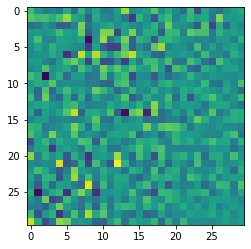

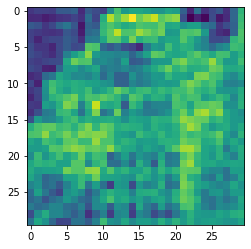

In [180]:
num_cell_h = int(num_cell_h)
cell_size_h = int(cell_size_h)
sparse_freq_h = int(sparse_freq_h)

W = V1_weights(num_cell_h, dim, cell_size_h, sparse_freq_h) 
y = generate_Y(W, img_arr)
W_model = W.reshape(num_cell_h, n, m)
theta, reform, s = compress(W_model, y, alpha_h)
error_h = np.linalg.norm(img - reform, 'fro') / np.sqrt(m*n)
print("Error:", error_h)

plt.imshow(img_arr - reform)
plt.show()
plt.imshow(reform)

Error: 3.0714767726619474
Error: 2.493480680781063
Error: 2.120148481892441
Error: 1.7512646519733785


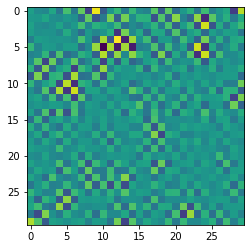

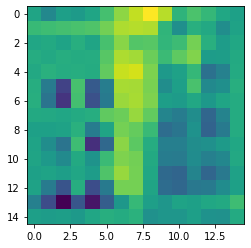

In [218]:
num_cell_h = int(num_cell_h)
cell_size_h = int(cell_size_h)
sparse_freq_h = int(sparse_freq_h)
img_arr_pt1 = img_arr[:15, :15]
img_arr_pt2 = img_arr[:15, 15:30]
img_arr_pt3 = img_arr[15:, :15]
img_arr_pt4 = img_arr[15:, 15:30]
img_pt = [img_arr_pt1, img_arr_pt2, img_arr_pt3, img_arr_pt4]
dim_pt = img_arr_pt1.shape
n_pt = dim_pt[0]
m_pt = dim_pt[1]

res = np.zeros(dim)
for i, pt in enumerate(img_pt):
    W = V1_weights(num_cell_h, dim_pt, cell_size_h, sparse_freq_h) 
    y = generate_Y(W, pt)
    W_model = W.reshape(num_cell_h, n_pt, m_pt)
    theta, reform, s = compress(W_model, y, alpha_h)
    error_h = np.linalg.norm(pt - reform, 'fro') / np.sqrt(m_pt*n_pt)
    print("Error:", error_h)
    if (i == 0):
        res[:15, :15] = reform
    elif (i == 1):
        res[:15, 15:30] = reform
    elif (i == 2):
        res[15:, :15] = reform
    elif (i == 3):
        res[15:, 15:30] = reform

plt.imshow(img_arr - res)
plt.show()
plt.imshow(reform)

In [219]:
img_arr - res

array([[ 7.07859546e-01, -6.60327861e-01, -1.00970067e+00,
         1.19264954e+00, -2.11615805e+00,  3.10394295e+00,
        -1.97687609e+00,  4.06274494e+00, -5.42610424e+00,
         7.72099396e+00, -3.91491328e+00,  6.44264236e-02,
         2.39450756e+00, -1.72089446e+00,  2.43741990e+00,
        -6.34526665e-01, -1.28080089e+00,  3.65266837e+00,
        -3.91551611e+00,  3.84288962e+00, -2.78032451e+00,
         3.61467671e-01,  1.91269569e+00, -2.07814297e+00,
         2.78554604e+00, -1.42764646e+00,  1.27622640e-01,
         1.25626274e+00, -5.79161858e+00,  6.31281823e+00],
       [ 2.82132159e-01,  1.20018763e-01,  1.11512988e+00,
        -3.81282479e-01, -6.67320592e-01,  1.90022642e-01,
        -3.69104253e-01, -3.17671654e+00,  4.03360067e+00,
        -4.45730912e+00, -1.88386197e+00,  4.66001036e+00,
        -3.71587328e+00,  4.51177246e+00, -6.18971273e-01,
         2.06028685e+00,  1.90698246e+00, -4.59264686e+00,
         3.46899354e+00, -3.77105671e+00,  5.15536346e+

In [143]:
# np.round()
reform

array([[168.3832361 , 169.21516966, 182.71766269, 186.03306727,
        174.67078715, 170.89231251, 182.53614564, 201.91278843,
        210.27355643, 193.12896072, 180.84769648, 187.4677887 ,
        183.80108973, 179.59479327, 183.42800039, 182.91325252,
        183.37064878, 189.2108347 , 194.00149801, 193.60408155,
        192.49964226, 187.46172628, 182.27081294, 184.32386761,
        180.24942818, 171.15552709, 174.02093215, 166.78131094,
        148.20897559, 152.40847567],
       [177.42184337, 181.59264393, 195.74781668, 187.11113719,
        160.38186406, 161.10008442, 187.64200622, 203.36359979,
        202.4762339 , 191.71084695, 180.24680791, 178.10643748,
        181.72140683, 190.06063621, 190.32856309, 179.00296362,
        169.87287556, 170.43413075, 179.30122706, 187.11476351,
        192.31513849, 192.51930599, 191.01481106, 193.7081273 ,
        188.41995745, 176.51586565, 174.16068123, 165.6087266 ,
        156.09696063, 171.51460472],
       [164.95246286, 178.3906

In [ ]:
V1_reform = opt_param['reform'].to_numpy()[0]
plt.figure(figsize= (3,3))
plt.axis('off')
plt.imshow(V1_reform)
# use format string to name it with params
plt.savefig("tree_reconstruction.png", dpi = 200)

# Try grayscale color map

# Store original image of gray scale

In [ ]:
params

In [ ]:
#Compress Sensing on function

In [ ]:
## Check if this function is applicable to regular compress sensing
classical_img = Image.open("image/tree_part1.jpg")
classical_img = ImageOps.grayscale(classical_img)
classical_arr = np.asarray(classical_img)
cn, cm = classical_arr.shape
print(cn, cm)
classical_samp = 500 #np.floor (cn * cm * 0.20).astype(int)


In [ ]:
classical_arr - classical_reform * 100

In [ ]:
alpha_list = [30, 3, .3, .0003, .0000003]

for alp in alpha_list:
    # Generate random indexes and find corresponding y value for each index
    rand_index = np.random.permutation(cn * cm)[:classical_samp]
    classical_Y = classical_arr.flatten()[rand_index]
    classical_Y = classical_Y.reshape(classical_samp, 1)

    # Generate C matrix
    C = np.eye(cn * cm)[rand_index, :] * np.sqrt(cn * cm)
    C3D = C.reshape(classical_samp, cn, cm)
    theta, classical_reform, s = compress(C3D, classical_Y, alp)

    plt.imshow(classical_reform)
    plt.title("Recon.(alp: " + str(alp) + ")")
    plt.show()

In [ ]:
# Preparation for sampling index images
subplot = np.zeros(cn*cm)
for i in range (len(subplot)):
    if (i in rand_index):
        subplot[i] = 1
subplot = subplot.reshape(n, m)     
subplot.shape

subplot_x = []
subplot_y = []
for i in range(cn):
    for j in range(cm):
        if subplot[i][j] == 1:
            subplot_y.append(i)
            subplot_x.append(j)
            
plt.imshow(classical_arr)
# plt.scatter(subplot_x, subplot_y, color = 'red', marker = '.')
plt.show()

In [ ]:
opt_hyperparams(params_df)

In [ ]:
img_list1 = ["image/tree_part1.jpg", "image/city_part2.png"]


for im in img_list1:
    img = Image.open(im)
    img = ImageOps.grayscale(img)
    img_arr = np.asarray(img)

    # V1 Variables
    num_cell = 500
    cell_size = 7
    sparse_freq = 2
    dim = img_arr.shape
    n,m = dim

    W = V1_weights(num_cell, dim, cell_size, sparse_freq) 
    y = generate_Y(W, img_arr)
    W_rev = W.reshape(num_cell, n, m)
    theta, reform, s = compress(W_rev, y, 0.01)
    plt.imshow(reform)
    plt.show()

In [ ]:
# Classical Method
tree_img = Image.open("image/tree_part1.jpg")
tree_img = ImageOps.grayscale(tree_img)
tree_img_arr = np.asarray(tree_img)

city_img = Image.open("image/city_part2.png")
city_img = ImageOps.grayscale(city_img)
city_img_arr = np.asarray(city_img)

# V1 Optimized Variables
classical_samp = 100
dim = tree_img_arr.shape
n, m = dim
alp = 0.003

rand_index_tree = np.random.permutation(n * m)[:classical_samp]
classical_Y_tree = tree_img_arr.flatten()[rand_index_tree]
classical_Y_tree = classical_Y_tree.reshape(classical_samp, 1)

rand_index_city = np.random.permutation(n * m)[:classical_samp]
classical_Y_city = city_img_arr.flatten()[rand_index_city]
classical_Y_city = classical_Y_city.reshape(classical_samp, 1)

# Generate C matrix for tree
C_tree = np.eye(n * m)[rand_index_tree, :] #* np.sqrt(n * m)
C3D_tree = C_tree.reshape(classical_samp, n, m)

# Generate C matrix for city
C_city = np.eye(n * m)[rand_index_city, :] #* np.sqrt(n * m)
C3D_city = C_city.reshape(classical_samp, n, m)



# Fetch into function
theta_tree, classical_recons_tree, s_tree = compress(C3D_tree, classical_Y_tree, alp)
theta_city, classical_recons_city, s_city = compress(C3D_city, classical_Y_city, alp)

In [ ]:
# Show Original/Reconstructed image
fig = plt.figure(figsize = (10, 10))

ax = fig.add_subplot(3, 2, 1)
plt.imshow(tree_img)
axes = plt.gca()
axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)

ax = fig.add_subplot(3, 2, 2)
plt.imshow(city_img)
axes = plt.gca()
axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)

ax = fig.add_subplot(3, 2, 3)
plt.imshow(classical_recons_tree)
axes = plt.gca()
axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)

ax = fig.add_subplot(3, 2, 4)
plt.imshow(classical_recons_city)
axes = plt.gca()
axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)

ax = fig.add_subplot(3, 2, 5)
plt.imshow(tree_img_arr - classical_recons_tree)
axes = plt.gca()
axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)

ax = fig.add_subplot(3, 2, 6)
plt.imshow(city_img_arr - classical_recons_city)
axes = plt.gca()
axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)



In [ ]:
# V1 Methods
tree_img = Image.open("image/tree_part1.jpg")
tree_img = ImageOps.grayscale(tree_img)
tree_img_arr = np.asarray(tree_img)

city_img = Image.open("image/city_part2.png")
city_img = ImageOps.grayscale(city_img)
city_img_arr = np.asarray(city_img)

# V1 Optimized Variables
num_cell = 100
cell_size = 7
sparse_freq = 2
dim = img_arr.shape
n,m = dim
alp = 1

W = V1_weights(num_cell, dim, cell_size, sparse_freq) 
y_tree = generate_Y(W, tree_img_arr)
y_city = generate_Y(W, city_img_arr)
W_rev = W.reshape(num_cell, n, m)
theta_tree, recons_tree, s_tree = compress(W_rev, y_tree, alp)
theta_city, recons_city, s_city = compress(W_rev, y_city, alp)

plt.imshow(recons_tree)

In [ ]:
# Show Original/Reconstructed image
fig = plt.figure(figsize = (10, 10))

ax = fig.add_subplot(3, 2, 1)
plt.imshow(tree_img)
axes = plt.gca()
axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)

ax = fig.add_subplot(3, 2, 2)
plt.imshow(city_img)
axes = plt.gca()
axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)

ax = fig.add_subplot(3, 2, 3)
plt.imshow(recons_tree)
axes = plt.gca()
axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)

ax = fig.add_subplot(3, 2, 4)
plt.imshow(recons_city)
axes = plt.gca()
axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)

ax = fig.add_subplot(3, 2, 5)
plt.imshow(tree_img_arr - recons_tree)
axes = plt.gca()
axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)

ax = fig.add_subplot(3, 2, 6)
plt.imshow(city_img_arr - recons_city)
axes = plt.gca()
axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)



In [ ]:
tree_img_arr

In [ ]:
classical_recons_tree

1. Save all the images for hyperparams, and hyperparams as well, save original image along with it
2. Try same with compress sensing
